In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sb
from typing import List
import loinchpo 
import re

In [3]:
# read the PrimeKG node file
nodes = pd.read_csv("./PrimeKG.csv")

# read loinc2hpo annotation file
annotation_file = pd.read_csv("./loinc2hpo-annotations.tsv",sep="\t")
annotations = loinchpo.AnnotationParser.parse_annotations(annotation_file)



# load dataset with clinical features and label
dataset = pd.read_excel("./dataSet.xlsx",dtype='object')

# load dataset with additional info for some variables
df_info_fumo = pd.read_excel('./T0.df_smoking_habits.xlsx")
df_phq9 = pd.read_excel("./T0.df_info_phq9.xlsx")
df_disease = pd.read_excel("./df_info_patologies.xlsx")
df_info_statins = pd.read_excel("./T0.df_statins.xlsx")
df_info_predimed = pd.read_excel("./T0.df_predimed.xlsx")


# gene expression
gene_expression = pd.read_csv("./RawCounts.samples.txt",sep="\t")

# Map the clinical features to phenotypes, drug, disease and exposure nodes of PrimeKG

In [6]:
# create the dictionary with name exame: loinc codes

name_exam_LOINC = {"Systolic_blood_pressure":'8480-6', 'Diastolic_blood_pressure':'8462-4',
                  "Heart_rate":'8867-4', 'Oxygen_saturation':'20564-1',
                  "Leukocytes":'26464-8', "Erythrocytes":'789-8', "Haemoglobin":'718-7','Haematocrit':'4544-3',
                  "MCV":'787-2', "MCH":'785-6', "MCHC":"786-4" , "RDW":"788-0", "Platelets":'26515-7',
                   'CRP':'1988-5', 'hs_CRP':'30522-7',"MPV":"32623-1", 
                   "Basophils_#":"26444-0", "Neutrophils_#":'26499-4',
                  'Lymphocytes_#': '26474-7', 'Monocytes_#':'26484-6', 'Eosinophils_#':'26449-9',
                  'Blood_sugar':'2339-0', 'Uric_acid':'3084-1', 
                   'GGT':'2324-2', "Total_bilirubin":'1975-2',
                  'hsTnI':'42757-5', 'Triglycerides':'2571-8', "Total_cholesterol":'2093-3',
                  "HDL_cholesterol":'2085-9', 'LDL_cholesterol':'2089-1', 
                  'HbA1c_IFCC':'4548-4'}

name_exam_normal_value = {"Systolic_blood_pressure":[120], 'Diastolic_blood_pressure':[80],
                          "Heart_rate":[60,100], 
                          'Oxygen_saturation':[95, 98],
                          "Leukocytes":[5, 10], 
                          "Erythrocytes":{1:[4.7, 6.1], 0:[4.2, 5.4]}, 
                          "Haemoglobin":{1:[14, 18], 0:[12.0, 16.0]},
                          'Haematocrit':{1:[42, 52], 0:[37, 47]},
                          "MCV":[80.0, 95], 
                          "MCH": [27 , 31], 
                          "MCHC": [32, 36] , 
                          "RDW":[11,14.5], 
                          "Platelets":[150, 400], 
                          "CRP":[1],    "hs_CRP":[1],
                          "MPV":[7.4, 10.4],
                          "Basophils_#":[0.025,0.1], "Neutrophils_#":[2.5,8],
                          'Lymphocytes_#': [1, 4], 'Monocytes_#':[0.1,0.7], 'Eosinophils_#':[0.05,0.5],
                          'Blood_sugar':[74,106], 
                          'Uric_acid':{1:[4.0,7], 0:[2.7, 6]}, 
                          'GGT':{1:[8, 38], "F_<45":[5, 27]}, "Total_bilirubin":[0.3, 1],
                          'hsTnI':{1:[36], 0:[15]}, 'Triglycerides':{1:[40, 160], 0:[35, 135]}, 
                          "Total_cholesterol":[50, 200],
                          "HDL_cholesterol":{1:[45], 0:[55]}, 'LDL_cholesterol':[130],
                          'HbA1c_IFCC':[20,38]}


# create the dictionary name: hpo phenotype for the name of 'exams' without a loinc code
name_exam_hpo = {"BMI >= 25, <= 29.9" : 'Overweight', 
                 "BMI >= 30, <= 34.9" : 'Class I obesity',
                "BMI >= 35, <= 39.9" : 'Class II obesity', 
                 "BMI >= 40" : 'Class III obesity'}


# risk factors
name_categorical_disaese_or_hpo = {"Family_history_of_cardiovascular_disease": ['Family history of heart disease'],
                            "Family_history_of_cerebrovascular_disease":['Family history of cerebrovascular disease'],
                                   'Hypertension':['hypertension'], 
                                   'Diabetes_mellitus':['diabetes mellitus (disease)',"type 2 diabetes mellitus"],
                                   'Hypercholesterolemia':['Hypercholesterolemia'], 
                                   'Anaemia':['anemia (disease)','deficiency anemia'],
                                   'Thrombophilia':['thrombophilia'],
                                  'Chronic kidney disease':['Chronic kidney disease']}

name_drug_drugbank_entities = {'NOA':['Apixaban','Dabigatran etexilate','Dabigatran', 'Edoxaban','Rivaroxaban','Betrixaban'],
                     'Beta_blockers':['Metoprolol','Atenolol','Propranolol','Labetalol','Carvedilol','Nebivolol','Arotinolol',
                        'Penbutolol','Nadolol','Esmolol','Betaxolol','Timolol','Sotalol','Carteolol','Alprenolol',
                        'Pindolol','Acebutolol','Bevantolol','Practolol','Oxprenolol','Celiprolol','Bopindolol',
                        'Bupranolol','Indenolol','Talinolol','Landiolol','Esatenolol','Cloranolol','Mepindolol',
                        'Epanolol','Tertatolol','Bisoprolol','Dexpropranolol'],
                      'ACE_Inhibitors':['Enalapril','Quinapril','Captopril','Benazepril','Ramipril','Perindopril',
                         'Trandolapril','Fosinopril','Moexipril','Lisinopril','Cilazapril','Spirapril',
                         'Epicaptopril','Temocapril','Zofenopril','Imidapril','Delapril'],
                      'Sartans':['Losartan','Irbesartan','Candesartan cilexetil','Candesartan','Tasosartan',
                                'Valsartan','Telmisartan','Olmesartan','Eprosartan','Forasartan','Saprisartan',
                                'Azilsartan medoxomil','Fimasartan'],
                      'Diuretics':['Conivaptan','Tolvaptan','Bumetanide','Furosemide','Bendroflumethiazide','Metolazone',
                         'Cyclopenthiazide','Chlorthalidone','Mebutizide','Epitizide',
                         'Trichlormethiazide','Hydrochlorothiazide','Triamterene','Amiloride','Eplerenone',
                         'Canrenone','Canrenoic acid','Spironolactone','Muzolimine','Tienilic acid',
                         'Etacrynic acid','Torasemide','Piretanide','Bumetanide','Furosemide','Cicletanine',
                         'Theobromine','Mersalyl','Clofenamide','Mefruside','Chlorthalidone','Clopamide',
                         'Quinethazone','Meticrane','Xipamide','Indapamide','Clorexolone','Fenquizone','Cyclothiazide',
                         'Methyclothiazide','Polythiazide','Chlorothiazide','Hydroflumethiazide'],
                      'Nitrates':['Nitrate'], 
                      'Calcium_antagonists_dihydropyridines':['Amlodipine','Nifedipine','Lidoflazine','Levamlodipine',
                                                             'Clevidipine','Benidipine','Cilnidipine','Lercanidipine',
                                                             'Barnidipine','Manidipine','Nilvadipine','Lacidipine','Nisoldipine',
                                                             'Nitrendipine','Nimodipine','Nicardipine','Isradipine',
                                                             'Felodipine'],
                      'Calcium_antagonists_not_dihydropyridines':['Bepridil','Diltiazem','Verapamil',
                                'Gallopamil','Fendiline','Mibefradil'],
                      'ASA':['Acetylsalicylic acid'], 'Clopidogrel':['Clopidogrel'], 'Warfarin':['Warfarin'],
                      'Oral_hypoglycemics':['Acarbose','Acetohexamide','Alogliptin','Benfluorex','Buformin',
                                           'Canagliflozin','Carbutamide','Chlorpropamide','Dapagliflozin',
                                           'Empagliflozin','Evogliptin','Gemigliptin','Glibornuride','Gliclazide',
                                           'Glimepiride','Glipizide','Gliquidone','Glisoxepide','Glyburide',
                                           'Glymidine','Linagliptin','Metahexamide','Metformin','Miglitol',
                                           'Mitiglinide','Nateglinide','Phenformin','Pioglitazone','Repaglinide',
                                           'Rosiglitazone','Saxagliptin','Sitagliptin','Tolazamide','Tolbutamide',
                                           'Troglitazone','Vildagliptin','Voglibose'],
                      'Insulin':['Insulin human'], 
                      'Anxiolytic_Antidepressant':['Paroxetine','Sertraline', 'Citalopram','Escitalopram','Fluoxetine',
                                                   'Fluvoxamine','Dapoxetine','Imipramine','Clomipramine','Trimipramine',
                                                   'Amitriptyline','Butriptyline','Doxepin','Dosulepin','Desipramine',
                                                   'Nortriptyline','Protriptyline','Nialamide','Phenelzine','Tranylcypromine',
                                                   'Toloxatone','Venlafaxine','Duloxetine','Mirtazapine','Reboxetine',
                                                  'Bupropion','Trazodone','Agomelatine','Lithium carbonate','Carbamazepine','Valproic acid',
                                                  'Diazepam','Nordazepam','Delorazepam','Chlordiazepoxide','Clorazepic acid',
                                                  'Clobazam','Prazepam','Halazepam','Medazepam','Pinazepam','Tofisopam',
                                                  'Ketazolam','Lorazepam','Oxazepam','Camazepam','Loprazolam','Alprazolam',
                                                  'Estazolam','Lormetazepam','Temazepam','Midazolam','Triazolam','Adinazolam',
                                                  'Brotizolam','Etizolam','Clotiazepam','Doxefazepam'],
                      'n_3_PUFA':['Omega-3 fatty acids'], 'Ezetimibe':['Ezetimibe']  }

# for statins we know the specific molecule, so 1 - 1 mapping with patients
name_drug_drugbank_entities_statin = {'Statins':['Atorvastatin','Lovastatin','Rosuvastatin','Simvastatin','Pravastatin']}


# NOTE: we know the specific disease for each patient, so 1 - 1 mapping with patients
disease_name_1to1_mapped_entities = {'Diseases_of_esophagus':['gastroesophageal reflux disease','esophagitis (disease)'],
                                     'Upper_gastrointestinal_congenital_anomalies':['hiatus hernia (disease)'],
                               'Intervertebral_disc_disorders':['cervical disc degenerative disorder',
                                                                'intervertebral disc degenerative disorder'],
                                'Psoriasis_and_related_disorders':['psoriasis'],
                                'Chronic_airway_obstruction':['chronic obstructive pulmonary disease'],
                                'Asthma':['allergic asthma','intrinsic asthma'],
                                'Nontoxic_nodular_goiter':['multinodular goiter','nodular goiter'],
                                     'Depression':['mixed anxiety and depressive disorder'],
                                     'Sleep_disorders':['obstructive sleep apnea syndrome'],
                                     'Hyperplasia_of_prostate':['benign prostatic hyperplasia (disease)'],
                                     'Gastritis_and_duodenitis':['gastritis','chronic atrophic gastritis'],
                                     'Viral_hepatitis':['hepatitis B virus infection','hepatitis C virus infection'],
                                     'Osteoporosis_osteopenia_and_pathological_fracture':['osteoporosis'],
                                     'Thyroiditis':['Hashimoto thyroiditis','thyroiditis (disease)'],
                                     'Hypothyroidism':['hypothyroidism'],
                                     'Chronic_liver_disease_and_cirrhosis':['fatty liver disease'],
                                     'Effects_of_other_external_causes':['drug allergy'],
                                     'Hereditary_hemolytic_anemias':['favism','beta thalassemia','alpha thalassemia'],
                                     'Cholelithiasis_and_cholecystitis':['cholelithiasis','nephrolithiasis'],
                                     'Allergic_rhinitis':['allergic rhinitis'],
                                     'Glaucoma':['glaucoma'],
                                     'Thyrotoxicosis_with_or_without_goiter':['Graves disease'],
                                     'Parkinsons_disease':['Parkinson disease'],
                                     'Diverticulosis_and_diverticulitis':['diverticulitis of colon'],
                                     'Migraine':['migraine disorder','migraine with aura'],
                                     'Other_diseases_of_blood_and_blood_forming_organs':['congenital factor V deficiency',
                                                                             'congenital prothrombin deficiency'],
                                     'Other_disorders_of_metabolism':['Gilbert syndrome',
                                                                     'pure mitochondrial myopathy'],
                                     'Nonspecific_findings_on_examination_of_blood':['Hyperuricemia',
                                                                     'Increased circulating ferritin concentration'],
                                     'Disorders_of_protein_plasma_amino_acid_transport_and_metabolism':['homocystinuria due to methylene tetrahydrofolate reductase deficiency']
                                    }


def annotate_patients_from_clinical_variables(name_exam_LOINC,name_exam_normal_value,
                                              patients_clinical_feature_dataset, annotations,
                                             include_normal):
    regex = "^0+(?!$)"
    dictionary_patient_list_annotation = {}
    
    lab_exam_with_normal_hpo_as_mean_lower_high = ["Systolic_blood_pressure", "Diastolic_blood_pressure" , 
                            "Total_cholesterol" ,"LDL_cholesterol", "HDL_cholesterol",
                           "Heart_rate" ,"Leukocytes","MCV" ,"MCH" ,"MCHC" ,"Platelets"  ,
                            "MPV" ,"Basophils_#" ,"Neutrophils_#" ,"Monocytes_#" ,
                            "Eosinophils_#" ,"Blood_sugar" ,"HbA1c_IFCC" ,"Oxygen_saturation",
                           "Erythrocytes", "Haemoglobin", "Haematocrit", "Uric_acid"]
    
    
    for index,row in tqdm(patients_clinical_feature_dataset.iterrows()):
        list_annotations_patient_i = []
        
        ################### lab and other exams ###################
        
        # BMI to hpo phenotype
        if (row['BMI'] >= 25 ) and (row['BMI'] <= 29.9 ):
            list_annotations_patient_i.append(['Overweight'])
            list_annotations_patient_i.append(['Increased body mass index'])
        elif (row['BMI'] >= 30 ) and (row['BMI'] <= 34.9 ):
            list_annotations_patient_i.append(['Class I obesity'])
            list_annotations_patient_i.append(['Increased body mass index'])
        elif (row['BMI'] >= 35 ) and (row['BMI'] <= 39.9 ):
            list_annotations_patient_i.append(['Class II obesity'])
            list_annotations_patient_i.append(['Increased body mass index'])
        elif (row['BMI'] >= 40 ):
            list_annotations_patient_i.append(['Class III obesity'])
            list_annotations_patient_i.append(['Increased body mass index'])
        elif (row['BMI'] < 18.5 ):
            list_annotations_patient_i.append(['Increased body weight'])
            list_annotations_patient_i.append(['Decreased body mass index'])
        else:
            if include_normal:
                list_annotations_patient_i.append(['Decreased body weight','Increased body weight'])
            else:
                pass

        
        if (row['Sex'] == 1):
            if (row['Abdominal_circumference']/row['Pelvis_circumference'])>=0.9:
                list_annotations_patient_i.append(['Increased waist to hip ratio'])
        elif (row['Sex'] == 0):
            if (row['Abdominal_circumference']/row['Pelvis_circumference'])>=0.85:
                list_annotations_patient_i.append(['Increased waist to hip ratio'])
            

        # lab exams to hpo with loinc2hpo annotations
        for lab_exam in name_exam_LOINC.keys():
            lab_exam_value = row[lab_exam]
            lab_exam_loinc_code = name_exam_LOINC[lab_exam]
            lab_exam_normal_range = name_exam_normal_value[lab_exam]
            
            ## transform the numerical value to discrete by looking at the normal range
            
            # normal value is defined by a number 
            if (lab_exam == "Systolic_blood_pressure" or 
                lab_exam == "Diastolic_blood_pressure" or 
                lab_exam == "LDL_cholesterol"):
                
                if lab_exam_value<lab_exam_normal_range[0]:
                    lab_exam_categorical_value = "L"
                    
                elif lab_exam_value>lab_exam_normal_range[0]:
                    lab_exam_categorical_value = "H"
                    
                else:
                    lab_exam_categorical_value = "N"
                    
                    
            if lab_exam == "HDL_cholesterol":
                lab_exam_normal_range = lab_exam_normal_range[row['Sex']]
                
                if lab_exam_value<lab_exam_normal_range[0]:
                    lab_exam_categorical_value = "L"
                    
                elif lab_exam_value>lab_exam_normal_range[0]:
                    lab_exam_categorical_value = "H"
                
                else:
                    lab_exam_categorical_value = "N"
                   
            # lab values with a range [min, max]
            if (lab_exam == "Heart_rate" or 
                  lab_exam == "Leukocytes" or
                  lab_exam == "MCV" or 
                  lab_exam == "MCH" or 
                  lab_exam == "MCHC" or
                  lab_exam == "Platelets"  or
                  lab_exam == "MPV" or 
                  lab_exam == "Basophils_#" or 
                  lab_exam == "Neutrophils_#" or 
                  lab_exam == "Lymphocytes_#" or 
                  lab_exam == "Monocytes_#" or 
                  lab_exam == "Eosinophils_#" or
                  lab_exam == "Blood_sugar" or 
                  lab_exam == "HbA1c_IFCC" or 
                  lab_exam == "Oxygen_saturation" or
                  lab_exam == "Total_cholesterol"):
            
                if lab_exam_value<lab_exam_normal_range[0]:
                    lab_exam_categorical_value = "L"

                elif lab_exam_value>lab_exam_normal_range[1]:
                    lab_exam_categorical_value = "H"
                    
                else:
                    lab_exam_categorical_value = "N"
            
            
            if (lab_exam == "Erythrocytes" or 
                lab_exam == "Haemoglobin" or 
                lab_exam == "Haematocrit" or 
                lab_exam == "Uric_acid" or 
                lab_exam == "Triglycerides"):
                
                lab_exam_normal_range = lab_exam_normal_range[row['Sex']]
                
                if lab_exam_value<lab_exam_normal_range[0]:
                    lab_exam_categorical_value = "L"

                elif lab_exam_value>lab_exam_normal_range[1]:
                    lab_exam_categorical_value = "H"
                
                else:
                    lab_exam_categorical_value = "N"
               
            # normal value is <=
            if (lab_exam == "CRP" or 
                lab_exam=="hs_CRP" or 
                lab_exam == "hsTnI" or 
                lab_exam == "RDW" or 
                lab_exam == "GGT" or 
                lab_exam == "Total_bilirubin"):
                
                if lab_exam == "CRP" or lab_exam=="hs_CRP":
                    lab_exam_normal_range = lab_exam_normal_range[0]
                    
                    if lab_exam_value>lab_exam_normal_range:
                        lab_exam_categorical_value = "H"
                    else:
                        lab_exam_categorical_value = "N"
                    
                
                elif lab_exam == "hsTnI":
                    lab_exam_normal_range = lab_exam_normal_range[row['Sex']][0]
                    
                    if lab_exam_value>lab_exam_normal_range:
                        lab_exam_categorical_value = "H"
                    else:
                        continue
                        
                elif lab_exam == "Total_bilirubin":
                    lab_exam_normal_range = lab_exam_normal_range[1]
                    
                    if lab_exam_value>lab_exam_normal_range:
                        lab_exam_categorical_value = "H"
                    elif lab_exam_value<lab_exam_normal_range:
                        lab_exam_categorical_value = "L"
                    else:
                        lab_exam_categorical_value = "N"
                
                elif lab_exam == "RDW":
                    lab_exam_normal_range = lab_exam_normal_range[1]
                    
                    if lab_exam_value>lab_exam_normal_range:
                        lab_exam_categorical_value = "H"
                    else:
                        continue

                elif lab_exam == "GGT":
                    if (row['Sex'] == 1) or (row['Sex'] == 0 and row['Age']>=45):
                        lab_exam_normal_range = lab_exam_normal_range[1][1]
                    else: 
                        lab_exam_normal_range = lab_exam_normal_range['F_<45'][1]
                        
                    if lab_exam_value>lab_exam_normal_range:
                        lab_exam_categorical_value = "H"
                    else:
                        continue
                
           
            # make the query with the annotations
            
            # if normal value included -> add both the lower and the higher annotation, the embedding will be the mean
            if include_normal == True:

                # normal value for mean
                if (lab_exam in lab_exam_with_normal_hpo_as_mean_lower_high) and (lab_exam_categorical_value=="N"):

                    query_L = loinchpo.Query(lab_exam_loinc_code, "L")
                    resolver_L = loinchpo.QueryResolver(annotations)
                    hpo_term_L = resolver_L.resolve(query_L)
                    hpo_term_L = str(re.sub(regex, "", hpo_term_L.split(":")[1]) )

                    query_H = loinchpo.Query(lab_exam_loinc_code, "H")
                    resolver_H = loinchpo.QueryResolver(annotations)
                    hpo_term_H = resolver_H.resolve(query_H)
                    hpo_term_H = str(re.sub(regex, "", hpo_term_H.split(":")[1]) )


                    PrimeKG_node_hpo_L = nodes[(nodes['node_source'] == "HPO") & (nodes['node_id'] == hpo_term_L)]['node_name'].item()
                    PrimeKG_node_hpo_H = nodes[(nodes['node_source'] == "HPO") & (nodes['node_id'] == hpo_term_H)]['node_name'].item()

                        
                    list_annotations_patient_i.append([PrimeKG_node_hpo_L,PrimeKG_node_hpo_H])

                # normal value for mean from CRP
                elif (lab_exam in ['CRP','hs_CRP']) and (lab_exam_categorical_value=="N"):

                    # look at the high and lower of CRP
                    query_L = loinchpo.Query('1988-5', "L")
                    resolver_L = loinchpo.QueryResolver(annotations)
                    hpo_term_L = resolver_L.resolve(query_L)
                    hpo_term_L = str(re.sub(regex, "", hpo_term_L.split(":")[1]) )

                    query_H = loinchpo.Query('1988-5', "H")
                    resolver_H = loinchpo.QueryResolver(annotations)
                    hpo_term_H = resolver_H.resolve(query_H)
                    hpo_term_H = str(re.sub(regex, "", hpo_term_H.split(":")[1]) )

                    PrimeKG_node_hpo_L = nodes[(nodes['node_source'] == "HPO") & (nodes['node_id'] == hpo_term_L)]['node_name'].item()
                    PrimeKG_node_hpo_H = nodes[(nodes['node_source'] == "HPO") & (nodes['node_id'] == hpo_term_H)]['node_name'].item()

                    list_annotations_patient_i.append([PrimeKG_node_hpo_L,PrimeKG_node_hpo_H])

                # low or high value for mean

                elif (lab_exam == "Total_bilirubin") and (lab_exam_categorical_value == "N"):
                    list_annotations_patient_i.append(["Hypobilirubinemia","Hyperbilirubinemia"])

                elif (lab_exam == "Total_bilirubin") and (lab_exam_categorical_value == "L"):
                    list_annotations_patient_i.append(["Hypobilirubinemia"])

                else:

                    # not mapped to Prime KG so choose a node manually
                    if (lab_exam_categorical_value=="H") and (lab_exam=="Triglycerides"):
                        list_annotations_patient_i.append(["Abnormal circulating lipid concentration"])
                        
                    elif (lab_exam_categorical_value=="N") and (lab_exam=="Triglycerides"):
                        list_annotations_patient_i.append(["Abnormal circulating lipid concentration","Hypotriglyceridemia"])

                    # not mapped to Prime KG so choose a node manually
                    elif (lab_exam_categorical_value=="L") and (lab_exam=="Lymphocytes_#"):
                        list_annotations_patient_i.append(["B lymphocytopenia","T lymphocytopenia"])

                    elif (lab_exam_categorical_value=="N") and (lab_exam=="Lymphocytes_#"):
                        list_annotations_patient_i.append(["B lymphocytopenia","T lymphocytopenia","Lymphocytosis"])

                    # query the low or high value
                    else:

                        query = loinchpo.Query(lab_exam_loinc_code, lab_exam_categorical_value)
                        resolver = loinchpo.QueryResolver(annotations)
                        hpo_term = resolver.resolve(query)
                        hpo_term = str(re.sub(regex, "", hpo_term.split(":")[1]) )


                        PrimeKG_node_hpo = nodes[(nodes['node_source'] == "HPO") & (nodes['node_id'] == hpo_term)]['node_name'].item()
                        list_annotations_patient_i.append([PrimeKG_node_hpo])

    
            # if not included the normal value -> continue if normal, otherwise add the lower or the higher
            else:
                
                if lab_exam_categorical_value=="N":
                    continue
                
                # not mapped to Prime KG so choose a node manually
                elif (lab_exam_categorical_value=="H") and (lab_exam=="Triglycerides"):
                    list_annotations_patient_i.append(["Abnormal circulating lipid concentration"])

                # not mapped to Prime KG so choose a node manually
                elif (lab_exam_categorical_value=="L") and (lab_exam=="Lymphocytes_#"):
                    list_annotations_patient_i.append(["B lymphocytopenia","T lymphocytopenia"])
                    
                elif (lab_exam == "Total_bilirubin") and (lab_exam_categorical_value == "L"):
                        list_annotations_patient_i.append(["Hypobilirubinemia"])

                # query the low or high value
                else:
                    
                    

                    query = loinchpo.Query(lab_exam_loinc_code, lab_exam_categorical_value)
                    resolver = loinchpo.QueryResolver(annotations)
                    hpo_term = resolver.resolve(query)
                    hpo_term = str(re.sub(regex, "", hpo_term.split(":")[1]) )


                    PrimeKG_node_hpo = nodes[(nodes['node_source'] == "HPO") & (nodes['node_id'] == hpo_term)]['node_name'].item()
                    list_annotations_patient_i.append([PrimeKG_node_hpo])
    
        ################### risk factors  ###################
        
        for risk_factor in name_categorical_disaese_or_hpo.keys():
            if row[risk_factor] == 1:
                list_annotations_patient_i.append(name_categorical_disaese_or_hpo[risk_factor])
                
        
        ################### drugs features ###################
        
        for drug in name_drug_drugbank_entities.keys():
            if row[drug] == 1:
                list_annotations_patient_i.append(name_drug_drugbank_entities[drug])
                    
        ######## statine
        df_info_statins_patients = df_info_statins[df_info_statins['Codice Epifania'] == row['Sample_ID']]
        
        
        if df_info_statins_patients['Il paziente assume statine?'].item()=="SI":
            if df_info_statins_patients['Molecola'].item()=="ATORVASTATINA":
                list_annotations_patient_i.append(['Atorvastatin'])
            elif df_info_statins_patients['Molecola'].item()=="LOVASTATINA":
                list_annotations_patient_i.append(['Lovastatin'])
            elif df_info_statins_patients['Molecola'].item()=="ROSUVASTATINA":
                list_annotations_patient_i.append(['Rosuvastatin'])
            elif df_info_statins_patients['Molecola'].item()=="SIMVASTATINA":
                list_annotations_patient_i.append(['Simvastatin'])
            elif df_info_statins_patients['Molecola'].item()=="PRAVASTATINA":
                list_annotations_patient_i.append(['Pravastatin'])
            
       
        ################### smoking habits  ###################
        
        # current smoker
        if row['Smoking_habits'] == 2:
            list_annotations_patient_i.append(['tobacco tar'])
            list_annotations_patient_i.append(['Tobacco Smoke Pollution'])
            list_annotations_patient_i.append(['Nicotine'])

        # ex-smoker
        elif row['Smoking_habits'] == 1:
            
            df_info_fumo_patient = df_info_fumo[df_info_fumo['Codice Epifania'] == row['Sample_ID']]
            
            # check if year of stop smoking present
            if not(df_info_fumo_patient['Anno di fine'].isna().item()):
                difference_visit_date_year_stop_smoking = (pd.to_datetime(df_info_fumo_patient['Data della visita'],format='%Y-%m-%d') - np.timedelta64(15, 'Y')).item().year
                
                if difference_visit_date_year_stop_smoking < int(df_info_fumo_patient['Anno di fine'].item()):
                    list_annotations_patient_i.append(['Tobacco Smoke Pollution'])
                    
            # otherwise use years of smoking
            else:
                difference_age_years_of_smoking = row['Age'] - df_info_fumo_patient['Anni da fumatore'].item()
                
                if difference_age_years_of_smoking < 15:
                    list_annotations_patient_i.append(['Tobacco Smoke Pollution'])
                
                
        ################### Score questionnaires ###################
    
        if row['Score_FSSQ'] >=24:
            list_annotations_patient_i.append(['Lack of peer relationships'])
            
        dict_phq9_conversion_string_number = {"Mai":0,
                                              "Molti giorni":1,
                                              "Più della metà dei giorni":2,
                                              "Quasi tutti i giorni":3}
        
        df_phq9_numeric = df_phq9.replace(dict_phq9_conversion_string_number)
            
        df_phq9_patient = df_phq9_numeric[df_phq9_numeric['Codice Epifania'] == row['Sample_ID']]
        
        if (df_phq9_patient['Il questionario PHQ-9/4 è stato compilato?'] == "SI").item():
            
            if df_phq9_patient['Scarso interesse o piacere nel fare le cose'].item()>=2:
                list_annotations_patient_i.append(['Diminished motivation'])
                
            if df_phq9_patient['Sentirsi giù, depresso o disperato'].item()>=2:
                list_annotations_patient_i.append(['Depressivity'])
                
            if df_phq9_patient['Difficoltà ad addormentarsi o mantenere il sonno, o dormire troppo'].item()>=2:
                list_annotations_patient_i.append(['Sleep disturbance'])
                
            if df_phq9_patient['Sentirsi stanco o avere poca energia'].item()>=2:
                list_annotations_patient_i.append(['Fatigue'])
                
            if df_phq9_patient['Scarso appetito o mangiare troppo'].item()>=2:
                list_annotations_patient_i.append(['Poor appetite','Polyphagia'])
                
            if df_phq9_patient['Sentirsi in colpa o di essere un fallito o di aver danneggiato se stesso o la sua famiglia'].item()>=2:
                list_annotations_patient_i.append(['Low self esteem'])
                
            if df_phq9_patient['Difficoltà a concentrarsi sulle cose, come leggere il giornale o guardare la televisione'].item()>=2:
                list_annotations_patient_i.append(['Diminished ability to concentrate'])
                
            if df_phq9_patient['Muoversi o parlare così lentamente tanto che anche gli atri se ne accorgono o, al contrario, essere così irrequieto o agitato da doversi muovere da ogni parte molto più del solito'].item()>=2:
                list_annotations_patient_i.append(['Hyperactivity','Restlessness','Weak voice'])
                                                  
            if df_phq9_patient['Pensare che sarebbe meglio essere morto o di farsi del male in qualche modo'].item()>=2:
                list_annotations_patient_i.append(['Suicidal ideation'])
                
            if df_phq9_patient['Sentirsi nervoso, ansioso o al limite'].item()>=2:
                list_annotations_patient_i.append(['Emotional insecurity'])
                
            if df_phq9_patient['Non essere in grado di smettere di preoccuparsi o di controllare le preoccupazioni'].item()>=2:
                list_annotations_patient_i.append(['Obsessive-compulsive behavior'])

                
        # mediterranean  minerals not included
        # Potassium, Phosphorus,Copper, Magnesium, Iron, Selenium, Zinc,Manganese
        if row['Score_PREDIMED'] >= 8: 
            list_annotations_patient_i.append(['Polyphenols','beta Carotene','Ascorbic Acid','alpha-Tocopherol',
                                              'Fatty Acids, Unsaturated','Vitamin A','Vitamin E','Vitamin B 6',
                                              'Folic Acid','Fatty Acids, Omega-3','alpha-Linolenic Acid','Phenols',
                                               'Omega-3 fatty acids','Docosahexaenoic Acids'])
            
            
        ############# disease ######################
        df_disease_patient = df_disease[df_disease['Sample_ID'] == row['Sample_ID']]
        
        for disease_name_feature in disease_name_1to1_mapped_entities.keys():
            if row[disease_name_feature] == 1:
                if disease_name_feature == "Upper_gastrointestinal_congenital_anomalies":
                    list_annotations_patient_i.append(['hiatus hernia (disease)'])
                    
                elif disease_name_feature == "Chronic_airway_obstruction":
                    list_annotations_patient_i.append(['chronic obstructive pulmonary disease'])
                     
                elif disease_name_feature == "Sleep_disorders":
                    list_annotations_patient_i.append(['obstructive sleep apnea syndrome'])
            
                elif disease_name_feature == "Depression":
                    list_annotations_patient_i.append(['mixed anxiety and depressive disorder'])
        
                elif disease_name_feature == "Hyperplasia_of_prostate":
                    list_annotations_patient_i.append(['benign prostatic hyperplasia (disease)'])
        
                elif disease_name_feature == "Osteoporosis_osteopenia_and_pathological_fracture":
                    list_annotations_patient_i.append(['osteoporosis'])
        
                elif disease_name_feature == "Hypothyroidism":
                    list_annotations_patient_i.append(['hypothyroidism'])
                    
                elif disease_name_feature == "Chronic_liver_disease_and_cirrhosis":
                    list_annotations_patient_i.append(['fatty liver disease'])
                    
                elif disease_name_feature == "Effects_of_other_external_causes":
                    list_annotations_patient_i.append(['drug allergy'])
                    
                elif disease_name_feature == "Allergic_rhinitis":
                    list_annotations_patient_i.append(['allergic rhinitis'])
                    
                elif disease_name_feature == "Glaucoma":
                    list_annotations_patient_i.append(['glaucoma'])
                    
                elif disease_name_feature == "Thyrotoxicosis_with_or_without_goiter":
                    list_annotations_patient_i.append(['Graves disease'])
                    
                elif disease_name_feature == "Parkinsons_disease":
                    list_annotations_patient_i.append(['Parkinson disease'])
                    
                elif disease_name_feature == "Diverticulosis_and_diverticulitis":
                    list_annotations_patient_i.append(['diverticulitis of colon'])
                    
                elif disease_name_feature == "Disorders_of_protein_plasma_amino_acid_transport_and_metabolism":
                    list_annotations_patient_i.append(['homocystinuria due to methylene tetrahydrofolate reductase deficiency'])    
                    
                ## check for the specific disease
                elif disease_name_feature == "Diseases_of_esophagus":
                    
                    specific_disease_patient_list = df_disease_patient[df_disease_patient['Phenotypes_ICD9_3char'] == disease_name_feature.replace("_"," ")]['Patologia'].values
                    for specific_disease_patient in specific_disease_patient_list:
                        if specific_disease_patient == "Gastroesophageal reflux disease" or specific_disease_patient == "Gastroesophageal reflux":
                            list_annotations_patient_i.append(['gastroesophageal reflux disease'])
                        elif specific_disease_patient == "Esophagitis":
                            list_annotations_patient_i.append(['esophagitis (disease)'])
                        
                elif disease_name_feature == "Intervertebral_disc_disorders":
                    specific_disease_patient_list = df_disease_patient[df_disease_patient['Phenotypes_ICD9_3char'] == disease_name_feature.replace("_"," ")]['Patologia'].values
                    for specific_disease_patient in specific_disease_patient_list:
                        if specific_disease_patient == "Herniated disc" or specific_disease_patient == "Intervertebral disc herniation" or specific_disease_patient == "Lumbar disc herniation" or specific_disease_patient == "Osteoarthritis of cervical spine":
                            list_annotations_patient_i.append(['intervertebral disc degenerative disorder'])
                        elif specific_disease_patient == "Cervical discopathy":
                            list_annotations_patient_i.append(['cervical disc degenerative disorder'])

                    
                elif disease_name_feature == "Asthma":
                    specific_disease_patient_list = df_disease_patient[df_disease_patient['Phenotypes_ICD9_3char'] == disease_name_feature.replace("_"," ")]['Patologia'].values
                    for specific_disease_patient in specific_disease_patient_list:
                        if specific_disease_patient == "Asthma" or specific_disease_patient == "Asthma NOS" or specific_disease_patient == "Asthma bronchial" or specific_disease_patient == "Asthma chronic" or specific_disease_patient == "Asthma unspecified type with status asthmaticus" or specific_disease_patient == "Asthmatic attack":
                            list_annotations_patient_i.append(['intrinsic asthma'])
                        elif specific_disease_patient == "Allergic asthma":
                            list_annotations_patient_i.append(['allergic asthma'])
                        
                        
                elif disease_name_feature == "Nontoxic_nodular_goiter":
                    specific_disease_patient_list = df_disease_patient[df_disease_patient['Phenotypes_ICD9_3char'] == disease_name_feature.replace("_"," ")]['Patologia'].values
                    for specific_disease_patient in specific_disease_patient_list:
                        if specific_disease_patient == "Thyroid cold nodule" or specific_disease_patient == "Thyroid nodular" or specific_disease_patient == "Thyroid nodule":
                            list_annotations_patient_i.append(['nodular goiter (disease)'])
                        elif specific_disease_patient == "Multinodular goiter":
                            list_annotations_patient_i.append(['multinodular goiter'])
                        
                        
                elif disease_name_feature == "Gastritis_and_duodenitis":
                    specific_disease_patient_list = df_disease_patient[df_disease_patient['Phenotypes_ICD9_3char'] == disease_name_feature.replace("_"," ")]['Patologia'].values
                    for specific_disease_patient in specific_disease_patient_list:
                        if specific_disease_patient == "Gastritis" or specific_disease_patient == "Gastritis NOS":
                            list_annotations_patient_i.append(['gastritis'])
                        elif specific_disease_patient == "Chronic gastritis":
                            list_annotations_patient_i.append(['chronic atrophic gastritis'])
                        
                elif disease_name_feature == "Viral_hepatitis":
                    specific_disease_patient_list = df_disease_patient[df_disease_patient['Phenotypes_ICD9_3char'] == disease_name_feature.replace("_"," ")]['Patologia'].values
                    for specific_disease_patient in specific_disease_patient_list:
                        if specific_disease_patient == "HBV DNA detectable" or specific_disease_patient == "Hepatitis B" or specific_disease_patient == "Hepatitis B antigen positive" or specific_disease_patient == "Hepatitis B virus test positive":
                            list_annotations_patient_i.append(['hepatitis B virus infection'])
                        elif specific_disease_patient == "Hepatitis C" or specific_disease_patient == "Hepatitis C test positive" or specific_disease_patient == "Hepatitis C virus test":
                            list_annotations_patient_i.append(['hepatitis C virus infection'])

                elif disease_name_feature == "Thyroiditis":
                    specific_disease_patient_list = df_disease_patient[df_disease_patient['Phenotypes_ICD9_3char'] == disease_name_feature.replace("_"," ")]['Patologia'].values
                    for specific_disease_patient in specific_disease_patient_list:
                        if specific_disease_patient == "Immune-mediated hypothyroidism" or specific_disease_patient == "Thyroiditis":
                            list_annotations_patient_i.append(['thyroiditis (disease)'])
                        elif specific_disease_patient == "Hashimoto's thyroiditis":
                            list_annotations_patient_i.append(['Hashimoto thyroiditis'])
                        
                elif disease_name_feature == "Hereditary_hemolytic_anemias":
                    specific_disease_patient_list = df_disease_patient[df_disease_patient['Phenotypes_ICD9_3char'] == disease_name_feature.replace("_"," ")]['Patologia'].values
                    for specific_disease_patient in specific_disease_patient_list:
                        if specific_disease_patient == "Thalassemia minor":
                            list_annotations_patient_i.append(['alpha thalassemia'])
                        elif specific_disease_patient == "Thalassemia beta" or specific_disease_patient == "Mediterranean anemia":
                            list_annotations_patient_i.append(['beta thalassemia'])
                        elif specific_disease_patient == "Favism":
                            list_annotations_patient_i.append(['favism'])
                        
                elif disease_name_feature == "Cholelithiasis_and_cholecystitis":
                    specific_disease_patient_list = df_disease_patient[df_disease_patient['Phenotypes_ICD9_3char'] == disease_name_feature.replace("_"," ")]['Patologia'].values
                    for specific_disease_patient in specific_disease_patient_list:
                        if specific_disease_patient == "Cholelithiasis" or specific_disease_patient == "Calculus in gallbladder" or specific_disease_patient == "Calculus of gallbladder without mention of cholecystitis":
                            list_annotations_patient_i.append(['cholelithiasis'])
                        elif specific_disease_patient == "Renal calculi":
                            list_annotations_patient_i.append(['nephrolithiasis'])
                        
                elif disease_name_feature == "Migraine":
                    specific_disease_patient_list = df_disease_patient[df_disease_patient['Phenotypes_ICD9_3char'] == disease_name_feature.replace("_"," ")]['Patologia'].values
                    for specific_disease_patient in specific_disease_patient_list:
                        if specific_disease_patient == "Migraine with aura":
                            list_annotations_patient_i.append(['migraine with aura'])
                        elif specific_disease_patient == "Migraine":
                            list_annotations_patient_i.append(['migraine disorder'])
                        
                elif disease_name_feature == "Other_diseases_of_blood_and_blood_forming_organs":
                    specific_disease_patient_list = df_disease_patient[df_disease_patient['Phenotypes_ICD9_3char'] == disease_name_feature.replace("_"," ")]['Patologia'].values
                    for specific_disease_patient in specific_disease_patient_list:
                        if specific_disease_patient == "Factor V Leiden heterozygote" or specific_disease_patient == "Factor V Leiden mutation" or specific_disease_patient == "Factor V Leiden thrombophilia":
                            list_annotations_patient_i.append(['congenital factor V deficiency'])
                        elif specific_disease_patient == "Prothrombin mutation G20210A":
                            list_annotations_patient_i.append(['congenital prothrombin deficiency'])
                        
                elif disease_name_feature == "Other_disorders_of_metabolism":
                    specific_disease_patient_list = df_disease_patient[df_disease_patient['Phenotypes_ICD9_3char'] == disease_name_feature.replace("_"," ")]['Patologia'].values
                    for specific_disease_patient in specific_disease_patient_list:
                        if specific_disease_patient == "Metabolic syndrome" or specific_disease_patient == "Mitochondrial myopathy":
                            list_annotations_patient_i.append(['pure mitochondrial myopathy'])
                        elif specific_disease_patient == "Gilbert's syndrome":
                            list_annotations_patient_i.append(['Gilbert syndrome'])
                            
                elif disease_name_feature == "Nonspecific_findings_on_examination_of_blood":
                    specific_disease_patient_list = df_disease_patient[df_disease_patient['Phenotypes_ICD9_3char'] == disease_name_feature.replace("_"," ")]['Patologia'].values
                    for specific_disease_patient in specific_disease_patient_list:
                        if specific_disease_patient == "Hyperuricemia":
                            list_annotations_patient_i.append(['Hyperuricemia'])
                        elif specific_disease_patient == "Hyperferritinemia":
                            list_annotations_patient_i.append(['Increased circulating ferritin concentration'])
                    
        # assign annotations to patient ID
        dictionary_patient_list_annotation[row['Sample_ID']] = list_annotations_patient_i
        
    return dictionary_patient_list_annotation

In [7]:
annotations_dict_NOT_include_normal = annotate_patients_from_clinical_variables(name_exam_LOINC,name_exam_normal_value,
                                              dataset, annotations, False)

723it [01:28,  8.20it/s]


In [8]:
import pickle
with open('./clinical_annotations.pkl', 'wb') as fp:
        pickle.dump(annotations_dict_NOT_include_normal,fp)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, '# of clinical annotations')

<Figure size 640x480 with 0 Axes>

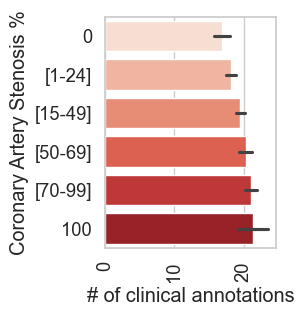

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(font_scale=1.5) 
sb.set_style("whitegrid")

plt.figure()
# read the results of the annotation -> not including normal -> each annotations a list of 1 or 2 l
import pickle
with open('./clinical_annotations.pkl', 'rb') as fp:
        dict_patient_clinical_feature_annotation_NOTincluding_normal_PrimeKG = pickle.load(fp) 
        
lists_annotations = []
lists_annotations_number = []
lists_annotations_class = []
lists_sap = []
for key, value in dict_patient_clinical_feature_annotation_NOTincluding_normal_PrimeKG.items():
    lists_annotations.append(value)
    lists_annotations_number.append(len(value))
    SAP = dataset[dataset['Sample_ID'] == key]['Stenosis_area_percentage'].item()
    if SAP == 0:
        lists_annotations_class.append("0")
    elif SAP > 0 and SAP < 25:
        lists_annotations_class.append("[1-24]")   
    elif SAP >= 25 and SAP < 50:
        lists_annotations_class.append("[15-49]")   
    elif SAP >= 50 and SAP < 70:
        lists_annotations_class.append("[50-69]")    
    elif SAP >= 70 and SAP < 100:
        lists_annotations_class.append("[70-99]")    
    elif SAP == 100:
        lists_annotations_class.append("100")   
    else:
        print(SAP)
    lists_sap.append(SAP)
        
sb.set_theme(style="whitegrid", font_scale=1.2)
        
plt.figure(figsize=(2.2,3))
df_annotations_NOTincluding_normal = pd.DataFrame({"Coronary Artery Stenosis (CAS) %" : lists_annotations_class, "Number of clinical annotations":lists_annotations_number})        
df_annotations_NOTincluding_normal['Coronary Artery Stenosis (CAS) %'] = pd.Categorical(df_annotations_NOTincluding_normal['Coronary Artery Stenosis (CAS) %'], categories=["0","[1-24]","[15-49]","[50-69]","[70-99]","100"], ordered=True)
df_annotations_NOTincluding_normal = df_annotations_NOTincluding_normal.sort_values(by='Coronary Artery Stenosis (CAS) %')
# including normal
a = sb.barplot(data=df_annotations_NOTincluding_normal, x="Number of clinical annotations", hue="Coronary Artery Stenosis (CAS) %",palette='Reds',y="Coronary Artery Stenosis (CAS) %")

plt.legend().remove()
plt.xticks(rotation = 90)
plt.ylabel(ylabel = "Coronary Artery Stenosis %", size=14.4)
plt.xlabel(xlabel = "# of clinical annotations", size=14.4)
#plt.savefig("./barplotd.png", dpi=500,bbox_inches = "tight")


# Mapping the gene variables to PrimeKG

In [80]:
# select all the nodes that mach a genes from the gene expressiond dataset
correctly_mappped_genes = list(nodes[(nodes['node_name'].isin(list(gene_expression['gene'].values))) & (nodes['node_type']=="gene/protein")]['node_name'])

In [81]:
np.save("./correctly_mapped_genes.npy",correctly_mappped_genes,allow_pickle=True)

# check alias in Entrez API

In [71]:
from Bio import Entrez 
# connect bio entrez
Entrez.email = "giuseppe.albi01@universitadipavia.it"
direct_access=Entrez.read(Entrez.einfo())

# example of search:
handle = Entrez.esearch(db="gene",term='CXorf40A AND Homo Sapiens [organism]')
record = Entrez.read(handle)

In [82]:
# for the remaining genes (not directly mapped), we look for an alias with Entrez in the gede database
gene_to_search_alias = list(set(gene_expression['gene']).difference(set(correctly_mappped_genes)))

In [85]:
alias = []
igs = []

for gene in tqdm(gene_to_search_alias):
    # define search string
    search_string = gene
    search_string += " AND Homo Sapiens [organism]"

    # find gene id
    handle = Entrez.esearch(db="gene",term=search_string)
    record = Entrez.read(handle)
    
    try:
        if len(record["IdList"])!=0:

            # search with id for more info
            record_with_aliases = Entrez.efetch(db="gene",id=record["IdList"][0],retmode="json")
            entry = record_with_aliases.read()

            # find official name
            entry.split("\n")[1][3:]
            alias.append(entry.split("\n")[1][3:])
            igs.append(gene)

        else:
            alias.append("no alias")
            igs.append(gene)
    except:
        print(gene)
        


  2%|█▏                                                                          | 503/33452 [06:25<8:11:39,  1.12it/s]

GPRACR


  2%|█▎                                                                         | 590/33452 [07:35<10:47:28,  1.18s/it]

LINC02527


  3%|██▏                                                                        | 952/33452 [12:01<10:28:53,  1.16s/it]

AP001066.1


  4%|███                                                                       | 1372/33452 [17:19<10:32:00,  1.18s/it]

LINC01928


  7%|█████▎                                                                    | 2422/33452 [30:46<10:26:38,  1.21s/it]

GSTA11P


  7%|█████▌                                                                     | 2482/33452 [31:36<8:53:48,  1.03s/it]

AHCYP4


  8%|█████▋                                                                     | 2562/33452 [32:39<7:52:59,  1.09it/s]

LINC02262


  8%|█████▉                                                                     | 2664/33452 [33:59<9:05:56,  1.06s/it]

AC092040.2


  9%|██████▉                                                                    | 3080/33452 [39:19<8:54:47,  1.06s/it]

LINC02302


 12%|████████▊                                                                  | 3924/33452 [50:29<7:50:24,  1.05it/s]

RPL6P21


 13%|█████████▋                                                                 | 4339/33452 [55:55<9:13:22,  1.14s/it]

RNA5SP27


 14%|██████████▎                                                                | 4581/33452 [59:04<7:52:07,  1.02it/s]

AC138625.1


 14%|██████████▍                                                              | 4759/33452 [1:01:10<8:27:07,  1.06s/it]

OR5D3P


 14%|██████████▎                                                             | 4776/33452 [1:01:24<10:57:38,  1.38s/it]

RNA5SP460


 16%|███████████▍                                                            | 5321/33452 [1:08:33<10:37:34,  1.36s/it]

IGLV10-67


 17%|████████████▊                                                            | 5843/33452 [1:15:38<8:40:41,  1.13s/it]

LINC02214


 20%|██████████████▎                                                          | 6536/33452 [1:24:30<9:19:45,  1.25s/it]

MIR3169


 20%|██████████████▎                                                          | 6554/33452 [1:24:43<8:22:23,  1.12s/it]

RNU6-912P


 20%|██████████████▋                                                          | 6745/33452 [1:27:07<7:17:32,  1.02it/s]

AC135776.3


 21%|██████████████▉                                                          | 6868/33452 [1:28:51<9:26:50,  1.28s/it]

RNU6-87P


 21%|███████████████▏                                                         | 6958/33452 [1:29:58<7:12:00,  1.02it/s]

OR10D1P


 21%|███████████████▎                                                         | 7021/33452 [1:30:51<8:31:52,  1.16s/it]

RNU6-836P


 25%|█████████████████▉                                                       | 8208/33452 [1:46:35<8:55:31,  1.27s/it]

MIR5591


 25%|██████████████████▏                                                      | 8329/33452 [1:48:14<8:57:16,  1.28s/it]

LINC00556


 26%|██████████████████▊                                                      | 8596/33452 [1:51:39<8:32:46,  1.24s/it]

AL022310.1


 27%|███████████████████▉                                                     | 9116/33452 [1:58:47<7:35:24,  1.12s/it]

CYCSP46


 27%|███████████████████▉                                                     | 9162/33452 [1:59:25<8:19:31,  1.23s/it]

H2AZ2P1


 28%|████████████████████                                                     | 9216/33452 [2:00:06<6:48:14,  1.01s/it]

IFNNP1


 28%|████████████████████▋                                                    | 9467/33452 [2:03:28<9:12:16,  1.38s/it]

RN7SL225P


 28%|████████████████████▋                                                    | 9490/33452 [2:03:46<9:10:05,  1.38s/it]

KRT18P23


 29%|█████████████████████▍                                                   | 9805/33452 [2:08:07<8:09:00,  1.24s/it]

OR10B1P


 30%|█████████████████████▉                                                  | 10179/33452 [2:12:59<7:08:22,  1.10s/it]

LINC01282


 31%|██████████████████████▋                                                 | 10533/33452 [2:17:38<5:38:24,  1.13it/s]

LDHBP3


 32%|███████████████████████▏                                                | 10763/33452 [2:20:46<7:26:22,  1.18s/it]

AKR1B1P2


 34%|████████████████████████▏                                               | 11218/33452 [2:26:50<6:56:32,  1.12s/it]

PKNOX2-AS1


 34%|████████████████████████▏                                               | 11231/33452 [2:27:01<7:04:56,  1.15s/it]

HMGN1P38


 34%|████████████████████████▋                                               | 11444/33452 [2:29:35<6:02:52,  1.01it/s]

RNA5SP377


 34%|████████████████████████▊                                               | 11500/33452 [2:30:20<6:03:59,  1.01it/s]

AC231533.2


 35%|█████████████████████████▏                                              | 11727/33452 [2:33:17<9:37:53,  1.60s/it]

RPL7AP9


 40%|████████████████████████████▍                                           | 13234/33452 [2:53:05<6:35:47,  1.17s/it]

RN7SL496P


 40%|████████████████████████████▉                                           | 13450/33452 [2:56:02<6:06:16,  1.10s/it]

AC004125.1


 41%|█████████████████████████████▎                                          | 13596/33452 [2:57:50<6:03:21,  1.10s/it]

LINC02850


 42%|██████████████████████████████▍                                         | 14137/33452 [3:04:45<6:01:11,  1.12s/it]

CDK5P1


 43%|███████████████████████████████                                         | 14409/33452 [3:08:05<5:35:47,  1.06s/it]

PPIAP54


 44%|███████████████████████████████▍                                        | 14620/33452 [3:10:50<5:52:34,  1.12s/it]

CICP19


 45%|████████████████████████████████▋                                       | 15162/33452 [3:17:48<6:11:11,  1.22s/it]

FAM240B


 46%|█████████████████████████████████▎                                      | 15464/33452 [3:21:27<5:17:34,  1.06s/it]

AC006277.1


 48%|██████████████████████████████████▍                                     | 15985/33452 [3:28:22<5:35:43,  1.15s/it]

ABI1P1


 48%|██████████████████████████████████▍                                     | 15989/33452 [3:28:27<6:18:13,  1.30s/it]

RPL21P133


 48%|██████████████████████████████████▋                                     | 16091/33452 [3:29:46<4:43:50,  1.02it/s]

MTND5P28


 48%|██████████████████████████████████▋                                     | 16114/33452 [3:30:05<5:22:58,  1.12s/it]

AP000523.1


 49%|███████████████████████████████████                                     | 16282/33452 [3:32:11<5:51:47,  1.23s/it]

SMARCE1P6


 50%|███████████████████████████████████▋                                    | 16605/33452 [3:36:43<5:00:11,  1.07s/it]

AC106806.2


 50%|███████████████████████████████████▉                                    | 16687/33452 [3:37:42<4:20:53,  1.07it/s]

LINC02291


 50%|████████████████████████████████████▎                                   | 16858/33452 [3:39:49<4:59:22,  1.08s/it]

U85056.1


 51%|████████████████████████████████████▋                                   | 17020/33452 [3:41:53<5:12:00,  1.14s/it]

FGF7P2


 51%|████████████████████████████████████▉                                   | 17164/33452 [3:43:39<4:45:22,  1.05s/it]

POLD2P1


 51%|█████████████████████████████████████                                   | 17205/33452 [3:44:07<4:28:23,  1.01it/s]

AP000324.1


 52%|█████████████████████████████████████▌                                  | 17457/33452 [3:47:12<4:24:52,  1.01it/s]

YWHAZP7


 53%|█████████████████████████████████████▉                                  | 17619/33452 [3:49:09<4:36:46,  1.05s/it]

AC000068.2


 53%|██████████████████████████████████████▏                                 | 17742/33452 [3:50:41<4:53:17,  1.12s/it]

OR9P1P


 54%|███████████████████████████████████████                                 | 18156/33452 [3:55:58<4:27:05,  1.05s/it]

AL031005.2


 55%|███████████████████████████████████████▎                                | 18253/33452 [3:57:15<4:48:13,  1.14s/it]

MIR3922


 55%|███████████████████████████████████████▍                                | 18323/33452 [3:58:15<5:30:46,  1.31s/it]

ZDHHC20P2


 55%|███████████████████████████████████████▍                                | 18325/33452 [3:58:18<6:12:43,  1.48s/it]

RN7SL690P


 56%|████████████████████████████████████████▌                               | 18838/33452 [4:05:06<5:01:59,  1.24s/it]

AL030996.1


 57%|████████████████████████████████████████▉                               | 19042/33452 [4:07:40<4:28:17,  1.12s/it]

RNU6-23P


 57%|█████████████████████████████████████████▍                              | 19227/33452 [4:10:16<4:05:36,  1.04s/it]

CD46P1


 58%|█████████████████████████████████████████▊                              | 19412/33452 [4:12:43<4:18:43,  1.11s/it]

RN7SL296P


 58%|██████████████████████████████████████████                              | 19523/33452 [4:14:10<4:24:15,  1.14s/it]

AC005537.2


 60%|███████████████████████████████████████████▎                            | 20137/33452 [4:21:59<4:03:18,  1.10s/it]

MIR1302-2HG


 61%|███████████████████████████████████████████▋                            | 20269/33452 [4:23:41<3:43:38,  1.02s/it]

RN7SL428P


 61%|███████████████████████████████████████████▉                            | 20442/33452 [4:26:27<3:40:27,  1.02s/it]

LINC01630


 62%|████████████████████████████████████████████▎                           | 20600/33452 [4:28:28<3:42:04,  1.04s/it]

WBP1LP10


 64%|█████████████████████████████████████████████▉                          | 21372/33452 [4:38:22<3:10:18,  1.06it/s]

C22orf24


 67%|████████████████████████████████████████████████▏                       | 22361/33452 [4:50:58<3:42:22,  1.20s/it]

PSMD4P1


 67%|████████████████████████████████████████████████▍                       | 22532/33452 [4:53:13<3:41:53,  1.22s/it]

MIR6845


 68%|████████████████████████████████████████████████▋                       | 22619/33452 [4:54:23<3:17:36,  1.09s/it]

C11orf40


 68%|█████████████████████████████████████████████████▎                      | 22905/33452 [4:58:05<3:17:08,  1.12s/it]

AC092656.1


 71%|███████████████████████████████████████████████████                     | 23731/33452 [5:08:48<3:28:16,  1.29s/it]

RNU6-937P


 71%|███████████████████████████████████████████████████▏                    | 23780/33452 [5:09:31<2:57:57,  1.10s/it]

AP005902.2


 73%|████████████████████████████████████████████████████▌                   | 24401/33452 [5:17:27<2:33:51,  1.02s/it]

SELENOWP1


 73%|████████████████████████████████████████████████████▉                   | 24570/33452 [5:19:49<2:48:50,  1.14s/it]

EIF4A1P11


 73%|████████████████████████████████████████████████████▉                   | 24579/33452 [5:19:59<3:35:39,  1.46s/it]

AC126121.2


 74%|█████████████████████████████████████████████████████▎                  | 24744/33452 [5:22:07<2:30:32,  1.04s/it]

RNU6-1255P


 75%|██████████████████████████████████████████████████████                  | 25125/33452 [5:26:48<2:28:36,  1.07s/it]

H3P15


 78%|████████████████████████████████████████████████████████▏               | 26079/33452 [5:39:53<2:15:01,  1.10s/it]

RNU7-155P


 78%|████████████████████████████████████████████████████████▏               | 26104/33452 [5:40:14<2:20:17,  1.15s/it]

AGGF1P10


 80%|█████████████████████████████████████████████████████████▊              | 26877/33452 [5:50:09<2:18:15,  1.26s/it]

ARL6IP1P3


 82%|██████████████████████████████████████████████████████████▋             | 27275/33452 [5:55:05<1:40:41,  1.02it/s]

SOCS5P5


 82%|██████████████████████████████████████████████████████████▉             | 27376/33452 [5:56:23<1:51:27,  1.10s/it]

LINC02114


 82%|███████████████████████████████████████████████████████████             | 27415/33452 [5:56:49<1:46:28,  1.06s/it]

LINC02846


 83%|███████████████████████████████████████████████████████████▋            | 27738/33452 [6:01:04<1:47:49,  1.13s/it]

CYMP-AS1


 84%|████████████████████████████████████████████████████████████▏           | 27991/33452 [6:04:32<1:34:53,  1.04s/it]

RPS27AP10


 84%|████████████████████████████████████████████████████████████▋           | 28209/33452 [6:07:15<1:19:13,  1.10it/s]

RN7SKP272


 85%|████████████████████████████████████████████████████████████▊           | 28280/33452 [6:08:11<1:48:23,  1.26s/it]

TMEM274P


 86%|█████████████████████████████████████████████████████████████▋          | 28649/33452 [6:12:42<1:23:05,  1.04s/it]

Z73965.1


 88%|███████████████████████████████████████████████████████████████▌        | 29544/33452 [6:23:54<1:06:17,  1.02s/it]

OR51N1P


 93%|████████████████████████████████████████████████████████████████████▍     | 30954/33452 [6:42:19<51:08,  1.23s/it]

CYCSP4


 93%|█████████████████████████████████████████████████████████████████████▏    | 31277/33452 [6:46:16<38:19,  1.06s/it]

LINC02572


 94%|█████████████████████████████████████████████████████████████████████▍    | 31397/33452 [6:47:37<38:40,  1.13s/it]

PLA2G12AP2


 95%|██████████████████████████████████████████████████████████████████████▎   | 31757/33452 [6:52:34<33:19,  1.18s/it]

RNU6-806P


 97%|███████████████████████████████████████████████████████████████████████▍  | 32286/33452 [6:59:28<23:30,  1.21s/it]

ARHGAP16P


 97%|███████████████████████████████████████████████████████████████████████▉  | 32498/33452 [7:02:20<18:51,  1.19s/it]

RNU6-1074P


 98%|████████████████████████████████████████████████████████████████████████▏ | 32629/33452 [7:04:03<20:02,  1.46s/it]

PPIAP59


 98%|████████████████████████████████████████████████████████████████████████▏ | 32642/33452 [7:04:13<14:20,  1.06s/it]

REREP2Y


100%|██████████████████████████████████████████████████████████████████████████| 33452/33452 [7:14:24<00:00,  1.28it/s]


In [86]:
# for some server request there was an error so we rerun again
no_select_one_other_run = ['GPRACR','LINC02527','AP001066.1','LINC01928','GSTA11P','AHCYP4','LINC02262',
                           'AC092040.2','LINC02302','RPL6P21','RNA5SP27','AC138625.1','OR5D3P','RNA5SP460',
                           'IGLV10-67','LINC02214','MIR3169','RNU6-912P','AC135776.3','RNU6-87P','OR10D1P',
                           'RNU6-836P','MIR5591','LINC00556','AL022310.1','CYCSP46','H2AZ2P1','IFNNP1',
                           'RN7SL225P','KRT18P23','OR10B1P','LINC01282','LDHBP3','AKR1B1P2','PKNOX2-AS1',
                           'HMGN1P38','RNA5SP377','AC231533.2','RPL7AP9','RN7SL496P','AC004125.1','LINC02850',
                           'CDK5P1','PPIAP54','CICP19','FAM240B','AC006277.1','ABI1P1','RPL21P133','MTND5P28',
                           'AP000523.1','SMARCE1P6','AC106806.2','LINC02291','U85056.1','FGF7P2','POLD2P1',
                           'AP000324.1','YWHAZP7','AC000068.2','OR9P1P','AL031005.2','MIR3922','ZDHHC20P2',
                           'RN7SL690P','AL030996.1','RNU6-23P','CD46P1','RN7SL296P','AC005537.2','MIR1302-2HG',
                           'RN7SL428P','LINC01630','WBP1LP10','C22orf24','PSMD4P1','MIR6845','C11orf40',
                           'AC092656.1','RNU6-937P','AP005902.2','SELENOWP1','EIF4A1P11','AC126121.2',
                           'RNU6-1255P','H3P15','RNU7-155P','AGGF1P10','ARL6IP1P3','SOCS5P5','LINC02114',
                           'LINC02846','CYMP-AS1','RPS27AP10','RN7SKP272','TMEM274P','Z73965.1','OR51N1P','CYCSP4',
                           'LINC02572','PLA2G12AP2','RNU6-806P','ARHGAP16P','RNU6-1074P','PPIAP59','REREP2Y']

In [87]:
# alias = []
# igs = []

for gene in tqdm(no_select_one_other_run):
    # define search string
    search_string = gene
    search_string += " AND Homo Sapiens [organism]"

    # find gene id
    handle = Entrez.esearch(db="gene",term=search_string)
    record = Entrez.read(handle)
    
    try:
        if len(record["IdList"])!=0:

            # search with id for more info
            record_with_aliases = Entrez.efetch(db="gene",id=record["IdList"][0],retmode="json")
            entry = record_with_aliases.read()

            # find official name
            entry.split("\n")[1][3:]
            alias.append(entry.split("\n")[1][3:])
            igs.append(gene)

        else:
            alias.append("no alias")
            igs.append(gene)
    except:
        print(gene)
        


100%|████████████████████████████████████████████████████████████████████████████████| 106/106 [02:06<00:00,  1.20s/it]


In [88]:
dict_gene_alias_mapping_primeKG = {}

for gene in list(correctly_mappped_genes):
    dict_gene_alias_mapping_primeKG[gene] = gene
        
for gene,alias in zip(igs,alias):
    if alias!='no alias':
        if alias not in correctly_mappped_genes:
            dict_gene_alias_mapping_primeKG[gene] = alias
        else:
            dict_gene_alias_mapping_primeKG[gene] = 'no alias' 
    
    else:
        dict_gene_alias_mapping_primeKG[gene] = 'no alias' 

In [95]:
import pickle
with open('./dict_gene_alias_mapping_primeKG.pkl', 'wb') as fp:
        pickle.dump(dict_gene_alias_mapping_primeKG,fp)